# Problem Set 2

## Introduction

In [1]:
import numpy as np
import scipy as sp
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.io import loadmat
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import time

### Load and plot the grids

In [2]:
grids = loadmat('FE_grid.mat',simplify_cells=True)
print(grids.keys())
coarse_grid = grids['FE_grid']['coarse']
# show the keys in the grid
print(coarse_grid.keys())
print("number of nodes:",coarse_grid['nodes'])
print("number of elements:",coarse_grid['elements'])
x=coarse_grid['coor'][:,0]
y=coarse_grid['coor'][:,1]
z=np.sin(np.pi*x)*np.cos(np.pi*y)
# be careful  the indices must start at 0, in mat files they start at one, so substract 1
triangles=np.concatenate(coarse_grid['theta'][0:5]-1)
T=tri.Triangulation(x,y,triangles)


dict_keys(['__header__', '__version__', '__globals__', 'FE_grid'])
dict_keys(['nodes', 'coor', 'elements', 'theta'])
number of nodes: 1333
number of elements: 2095


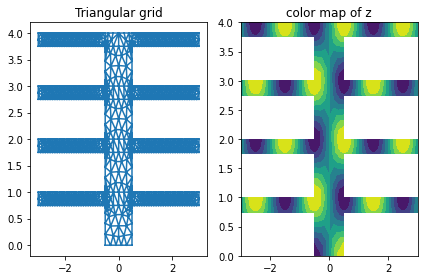

In [3]:
def plot(mesh,u):
    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs = axs.flatten()

    # Plot the triangulation.
    axs[0].triplot(mesh)
    axs[0].set_title('Triangular grid')

    # Plot the color map.
    axs[1].tricontourf(mesh,u)
    axs[1].set_title('color map of z')
    fig.tight_layout()
    plt.show()
plot(T,z)


### Load the matrices

In [4]:
M = loadmat('FE_matrix.mat',simplify_cells=True)
Aq_coarse=M['FE_matrix']['coarse']['Ahq']
Fh_coarse=M['FE_matrix']['coarse']['Fh']

### Solve the finite element problem

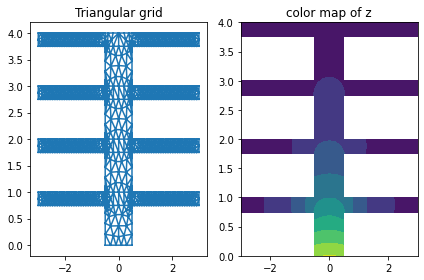

In [5]:
def assembleA(mu,Aq):
    A=csc_matrix(mu[0]*Aq[0])
    for k in range(1,6):
        A+=mu[k]*Aq[k]
    return A
k_i=1
Bi=0.1
mu=np.array([k_i,k_i, k_i, k_i, 1, Bi])
A=assembleA(mu,Aq_coarse)
N_cal = A.shape[0]
u = spsolve(A, Fh_coarse)
plot(T,u)

## Reduce Basis Approximation

On va créer une classe `reduce_basis` héritant de la classe `finite_element` :

In [6]:
class finite_element():
    def __init__(self,type): #type = 'coarse','medium','fine'
        M = loadmat('FE_matrix.mat',simplify_cells=True)
        self.A_N_cal_q = M['FE_matrix'][type]['Ahq']
        self.N_cal = self.A_N_cal_q[0].shape[0]
        self.F_N_cal = M['FE_matrix'][type]['Fh']
        self.L_N_cal = self.F_N_cal

    def get_A_N_cal(self,mu):
        return assembleA(mu,self.A_N_cal_q)
    
    def get_u_N_cal(self,mu):
        A = self.get_A_N_cal(mu)
        return spsolve(A, self.F_N_cal)
    
    def get_T_root_N_cal(self,mu):
        return self.L_N_cal.T @ self.get_u_N_cal(mu)

In [7]:
class reduce_basis(finite_element):
    def __init__(self,type,sample,ortho):
        super().__init__(type)

        self.S_N = self.__charge_S_N(sample)
        self.Z_complet = self.__charge_Z()
        if ortho==True:
            k_i=1.
            Bi=0.1
            mu_prod=np.array([k_i,k_i, k_i, k_i, 1., Bi])
            A_prod = self.get_A_N_cal(mu_prod)

            self.Z_complet = self.__gramm_schmidt(A_prod)
            #check orthonormality
            assert np.max(np.abs(np.eye(self.N) - self.Z_complet.T @ A_prod @self.Z_complet)) < 1e-6
        self.Z = self.Z_complet

        self.A_N_q = self.__charge_A_N_q()
        self.F_N = self.Z.T @ self.F_N_cal
        self.L_N = self.F_N


    def __charge_sample(self,sample):
        return loadmat('RB_sample.mat',simplify_cells=True)['RB_sample']['sample'+str(sample)]
    
    def __charge_S_N(self,s):
        sample = self.__charge_sample(s)
        self.N = sample.shape[0]
        if s==3:
            self.N = sample[0].shape[0]
        
        S_N=[]
        for i in range(self.N):
            if s==1:
                k_i = sample[i]
                mu_i = [k_i,k_i, k_i, k_i, 1, 0.1]
            elif s==2:
                Bi = sample[i]
                mu_i = [0.4, 0.6, 0.8, 1.2, 1, Bi]
            elif s==3:
                k_i = sample[0][i]
                Bi = sample[1][i]
                mu_i = [k_i,k_i, k_i, k_i, 1, Bi]
            S_N.append(mu_i)
        return np.array(S_N)

    def __charge_Z(self):
        Z = np.zeros((self.N_cal,self.N))
        for i in range(self.N):
            Z[:,i]=self.get_u_N_cal(self.S_N[i])
        return Z

    def prod_scalaire(self,u,v,A_prod):
            return u.T @ A_prod @ v

    def norme(self,u,A_prod):
        return np.sqrt(self.prod_scalaire(u,u,A_prod))
    
    def __gramm_schmidt(self,A_prod):
        Q = np.zeros((self.Z_complet.shape[0],self.Z_complet.shape[1]))
        for i in range(self.Z_complet.shape[1]):
            u = self.Z_complet[:,i]
            for j in range(i):
                u -= self.prod_scalaire(self.Z_complet[:,i],Q[:,j],A_prod)*Q[:,j]
            Q[:,i] = u/self.norme(u,A_prod)
        return Q
    
    def __charge_A_N_q(self):
        A_N_q = []
        for i in range(6):
            A_N_q.append(self.Z.T @ self.A_N_cal_q[i] @ self.Z)
        return np.array(A_N_q)
    
    def get_A_N(self,mu):
        return assembleA(mu,self.A_N_q)

    def get_u_N(self,mu): # u_N(mu)
        A = self.get_A_N(mu)
        return np.linalg.solve(A, self.F_N)
    
    def get_T_root_N(self,mu):
        return self.L_N.T @ self.get_u_N(mu)
    
    def change_N(self,N):
        if N!=0 and N<self.N:
            self.Z = self.Z_complet[:,:N]
        else:
            self.Z=self.Z_complet
        self.A_N_q = self.__charge_A_N_q()
        self.F_N = self.Z.T @ self.F_N_cal
        self.L_N = self.F_N


## Question a

Montrons que le nombre d'opérations pour l'étape online du code est indépendant de $\mathcal{N}$. En particulier, montrons que le nombre d'opérations pour l'étape online, pour chaque nouvelle $\mu$ d'intérêt, peut être exprimé comme suit
$$c_1N^{\gamma_1}+c_2N^{\gamma_2}+c_3N^{\gamma_3}$$

* La première partie de l'étape online est la construction de $A_N(\mu)$.

    Comme $A_N^q$ est déjà construite (dans la partie 4 de l'étape offline) et 
    $$A_N(\mu)=\sum_{q=1}^{Q}\theta^q(\mu)A_N^q$$
    On fait alors $Q*N^2$ opérations et ainsi $c_1=Q$ et $\gamma_1=2$.

* La deuxième partie consiste à résoudre
    $$A_N(\mu)u_N(\mu)=F_N$$
    En passant par une décomposition LU, on fait $N^3$ opérations et ainsi $c_2=1$ et $\gamma_2=3$.

* Pour la troisième partie on cherche à évaluer la sortie
    $$T_{root\; N}(\mu)=L_N^Tu_N(\mu)$$
    Comme $u_N(\mu)$ est déjà calculée dans la partie 2 de l'étape online et comme $L_N^T$ est déjà calculée dans la partie 4 de l'étape offline, on fait $N$ opérations donc $c_3=1$ et $\gamma_3=1$.

## Question b

Dans cette question, on va garder notre nombre de Biot Bi fixe et considérer que $k_1=k_2=k_3=k_4$ mais qu'ils peuvent varier entre 0.1 et 10. 

Nous considérerons également l'échantillon `RB_sample.sample1` (où $N=8$).

Créons 2 objets de la classe `reduce_basis` (une avec snapshots et une avec Gramm Schmidt) :

In [8]:
Bi=0.1
sample=1

In [9]:
def construct_mu(k_i):
    return np.array([k_i,k_i, k_i, k_i, 1., Bi])

In [10]:
RB_coarse_snapshots = reduce_basis('coarse',sample,False)
RB_coarse_gramm_schmidt = reduce_basis('coarse',sample,True)

### Question 1

#### Conditionnements de $A_N(\mu)$ :

In [11]:
k_i=1.
mu=construct_mu(k_i)
A_N = assembleA(mu,RB_coarse_snapshots.A_N_q)
print("Cond snapshots : ",np.linalg.cond(A_N))

A_N = assembleA(mu,RB_coarse_gramm_schmidt.A_N_q)
print("Cond Gram Schmidt : ",np.linalg.cond(A_N))

Cond snapshots :  275273672210.17535
Cond Gram Schmidt :  1.0000000012212604


In [12]:
k_i=10.
mu=construct_mu(k_i)
A_N = assembleA(mu,RB_coarse_snapshots.A_N_q)
print("Cond snapshots : ",np.linalg.cond(A_N))

A_N = assembleA(mu,RB_coarse_gramm_schmidt.A_N_q)
print("Cond Gram Schmidt : ",np.linalg.cond(A_N))

Cond snapshots :  134650339014.31348
Cond Gram Schmidt :  9.928605813508169


On constate donc que l'orthogonalisation de Gram_Schmidt permet un bien meilleur conditionnement de notre matrice $A_N(\mu)$.

#### Snapshots vs Gram-Schmidt

In [13]:
for k_i in [0.1,10,1.0975]:
    print("k_i =",k_i)
    mu = construct_mu(k_i)
    print("Snapshots : ",RB_coarse_snapshots.get_u_N(mu))
    print("Gram-Schmidt : ",RB_coarse_gramm_schmidt.get_u_N(mu))
    print()

k_i = 0.1
Snapshots :  [ 9.99792525e-01  4.58610437e-06  7.57949797e-05 -1.45268706e-05
 -3.26431944e-04 -1.79750195e-05  1.29997950e-05  4.73027599e-04]
Gram-Schmidt :  [ 1.91716756e+00  1.45459580e-14  1.75109331e-14 -4.65258037e-15
  4.80291735e-15 -9.17164505e-16  9.88300528e-16 -4.38255127e-16]

k_i = 10
Snapshots :  [-3.47755355e-06  1.00000015e+00  1.39836281e-06 -4.45494814e-07
 -5.64805387e-06 -3.75896270e-07  3.71074503e-07  8.02735409e-06]
Gram-Schmidt :  [ 7.38758647e-01  8.77362719e-01  9.70781706e-16  6.66944103e-16
  1.16136868e-16 -4.34553613e-16 -1.08358172e-16 -3.77543853e-16]

k_i = 1.0975
Snapshots :  [ 2.05511061  0.2877619  -1.32616721 -1.15988627  3.90430638  0.70152998
  1.58087281 -5.04352821]
Gram-Schmidt :  [ 1.03354441e+00  6.71854817e-01  2.04094195e-01  6.23943023e-02
 -9.38130901e-03  4.11523338e-03  5.73808317e-04 -5.27702150e-05]



### Question 2

In [14]:
modele = RB_coarse_gramm_schmidt

In [15]:
k_i=1.5
mu = construct_mu(k_i)
print("T_root_N :", modele.get_T_root_N(mu))

T_root_N : 1.53107497078964


### Question 3

On introduit ici un échantillon $test$ de taille 100 pour faire varier $k_i$ entre 0.1 et 10. 

On cherche à plot la maximum de notre erreur relative pour la norme d'énergie :
$$max_{\mu\in test}\frac{|||u(\mu)-u_N(\mu)|||_\mu}{|||u(\mu)|||_\mu}$$
et le maximum de l'erreur relative sur notre sortie:
$$max_{\mu\in test}\frac{|T_{root}(\mu)-T_{root\; N}(\mu)|}{T_{root}(\mu)}$$

In [16]:
def error(modele):
    mu_prod = mu_prod = np.array([1., 1., 1., 1., 1., 0.1])
    A_prod = modele.get_A_N_cal(mu_prod)

    tab_k_i=np.linspace(0.1,10,100)
    tab_max_norme_energie=[]
    tab_max_output_error=[]
    for n in range(1,modele.N+1):
        modele.change_N(n)
        max_norme_energie=0
        max_output_error=0
        for k_i in tab_k_i:
            mu = construct_mu(k_i)

            u_N = modele.get_u_N(mu)
            u_N_cal = modele.get_u_N_cal(mu)
            val = modele.norme(u_N_cal-modele.Z@u_N,A_prod)/modele.norme(u_N_cal,A_prod)
            # = np.sqrt(T_root_N_cal-T_root_N)/modele.norme(u_N_cal,A_prod)
            if(val>max_norme_energie):
                max_norme_energie=val

            T_root_N_cal = modele.get_T_root_N_cal(mu)
            T_root_N = modele.get_T_root_N(mu)
            val = np.abs(T_root_N_cal-T_root_N)/T_root_N_cal
            if(val>max_output_error):
                max_output_error=val
        
        tab_max_norme_energie.append(max_norme_energie)
        tab_max_output_error.append(max_output_error)

    return tab_max_norme_energie,tab_max_output_error

In [17]:
tab_max_norme_energie,tab_max_output_error=error(modele)

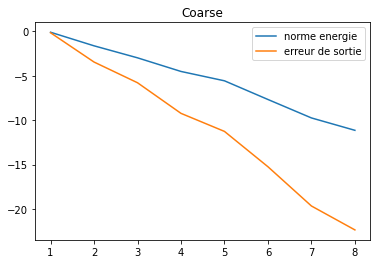

In [18]:
plt.plot(np.linspace(1,modele.N,modele.N),np.log(tab_max_norme_energie),label="norme energie")
plt.plot(np.linspace(1,modele.N,modele.N),np.log(tab_max_output_error),label="erreur de sortie")
plt.title("Coarse")
plt.legend();

### Question 4

Comparons le temps moyen du processeur sur l'échantillon de test requis pour résoudre l'étape de base réduite online avec la solution directe de l'approximation FE en fonction de N.

In [19]:
def compute_time(modele):
    tab_k_i=np.linspace(0.1,10,100)
    tab_time_BR=[]
    tab_time_FE=[]
    for n in range(1,modele.N+1):
        modele.change_N(n) #offline
        deb = time.time()
        for k_i in tab_k_i:
            mu = construct_mu(k_i)
            u_N = modele.get_u_N(mu)
            u_N_cal_approach = modele.Z @ u_N
            #T_root_N = modele.get_T_root_N(mu)
        fin = time.time()
        tab_time_BR.append(fin-deb)
        deb = time.time()
        for k_i in tab_k_i:
            mu = construct_mu(k_i)
            u_N_cal = modele.get_u_N_cal(mu)
            #T_root_N_cal = modele.get_T_root_N_cal(mu)
        fin = time.time()
        tab_time_FE.append(fin-deb)

    return tab_time_BR,tab_time_FE

In [20]:
tab_time_BR,tab_time_FE = compute_time(modele)
tab_time_BR = np.array(tab_time_BR)[:, np.newaxis]
tab_time_FE = np.array(tab_time_FE)[:, np.newaxis]
print("N, t_BR, t_FE")
for i,t in enumerate(np.concatenate([tab_time_BR,tab_time_FE],axis=1)):
    print(i+1,t[0],t[1])

N, t_BR, t_FE
1 0.04234027862548828 0.3856046199798584
2 0.02150726318359375 0.49592113494873047
3 0.05004763603210449 0.5518789291381836
4 0.05205559730529785 0.5433764457702637
5 0.04802680015563965 0.4854719638824463
6 0.04702162742614746 0.5862171649932861
7 0.8834035396575928 0.5677156448364258
8 0.04526543617248535 0.37005138397216797


### Question 5

On cherche maintenant à déterminer pour quelle valeur de N nous obtenons une précision relative de la sortie de 1%.

In [21]:
for n in range(len(tab_max_output_error)):
    if tab_max_output_error[n]<0.01:
        break
N_pourcentage_erreur = n+1
print("Pour N =",N_pourcentage_erreur,"notre erreur relative sur la sortie est inférieur à 1%.")

Pour N = 3 notre erreur relative sur la sortie est inférieur à 1%.


In [22]:
rapport = tab_time_FE[N_pourcentage_erreur-1][0]/tab_time_BR[N_pourcentage_erreur-1][0]
print("Pour une erreur de 1%, on constate que la méthode RB est ",rapport," fois plus rapide que la méthdoe FE.")


Pour une erreur de 1%, on constate que la méthode RB est  11.02707286282543  fois plus rapide que la méthdoe FE.


### Question 6

On va reprendre les questions précécentes en considérant cette fois les maillages `medium` et `fine`.

Medium :

In [23]:
modele = reduce_basis('medium',sample,True)
tab_max_norme_energie,tab_max_output_error=error(modele)

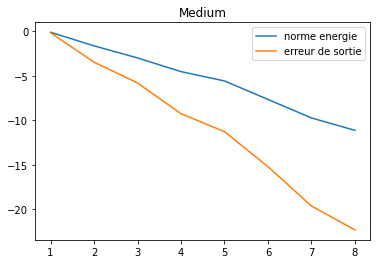

In [24]:
plt.plot(np.linspace(1,modele.N,modele.N),np.log(tab_max_norme_energie),label="norme energie")
plt.plot(np.linspace(1,modele.N,modele.N),np.log(tab_max_output_error),label="erreur de sortie")
plt.title("Medium")
plt.legend();

In [25]:
for n in range(len(tab_max_output_error)):
    if tab_max_output_error[n]<0.01:
        break
N_pourcentage_erreur = n+1
print("Pour N =",N_pourcentage_erreur,"notre erreur relative sur la sortie est inférieur à 1%.")

Pour N = 3 notre erreur relative sur la sortie est inférieur à 1%.


In [26]:
tab_time_BR,tab_time_FE = compute_time(modele)
tab_time_BR = np.array(tab_time_BR)[:, np.newaxis]
tab_time_FE = np.array(tab_time_FE)[:, np.newaxis]
print("N, t_BR, t_FE")
for i,t in enumerate(np.concatenate([tab_time_BR,tab_time_FE],axis=1)):
    print(i+1,t[0],t[1])

N, t_BR, t_FE
1 0.03146696090698242 1.2296617031097412
2 0.03916287422180176 1.2015838623046875
3 0.03959488868713379 1.1942667961120605
4 0.04324841499328613 1.1407747268676758
5 0.04354548454284668 1.192418098449707
6 0.03887009620666504 1.1345596313476562
7 0.046079158782958984 1.1911699771881104
8 0.04854249954223633 1.3878555297851562


In [27]:
rapport = tab_time_FE[N_pourcentage_erreur-1][0]/tab_time_BR[N_pourcentage_erreur-1][0]
print("Pour une erreur de 1%, on constate que la méthode RB est ",rapport," fois plus rapide que la méthdoe FE.")

Pour une erreur de 1%, on constate que la méthode RB est  30.162145562493603  fois plus rapide que la méthdoe FE.


Fine :

In [28]:
modele = reduce_basis('fine',sample,True)
tab_max_norme_energie,tab_max_output_error=error(modele)

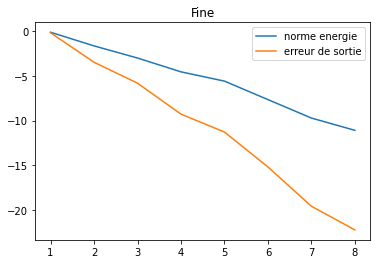

In [29]:
plt.plot(np.linspace(1,modele.N,modele.N),np.log(tab_max_norme_energie),label="norme energie")
plt.plot(np.linspace(1,modele.N,modele.N),np.log(tab_max_output_error),label="erreur de sortie")
plt.title("Fine")
plt.legend();

In [30]:
for n in range(len(tab_max_output_error)):
    if tab_max_output_error[n]<0.01:
        break
N_pourcentage_erreur = n+1
print("Pour N =",N_pourcentage_erreur,"notre erreur relative sur la sortie est inférieur à 1%.")

Pour N = 3 notre erreur relative sur la sortie est inférieur à 1%.


In [31]:
tab_time_BR,tab_time_FE = compute_time(modele)
tab_time_BR = np.array(tab_time_BR)[:, np.newaxis]
tab_time_FE = np.array(tab_time_FE)[:, np.newaxis]
print("N, t_BR, t_FE")
for i,t in enumerate(np.concatenate([tab_time_BR,tab_time_FE],axis=1)):
    print(i+1,t[0],t[1])

N, t_BR, t_FE
1 0.07887077331542969 4.991204261779785
2 0.21428203582763672 5.588414430618286
3 0.040851593017578125 4.9802329540252686
4 0.04184675216674805 5.0656304359436035
5 0.04918360710144043 4.973957300186157
6 0.046837806701660156 4.9795451164245605
7 0.047369956970214844 4.9925432205200195
8 0.03891134262084961 5.690176486968994


In [32]:
rapport = tab_time_FE[N_pourcentage_erreur-1][0]/tab_time_BR[N_pourcentage_erreur-1][0]
print("Pour une erreur de 1%, on constate que la méthode RB est ",rapport," fois plus rapide que la méthdoe FE.")

Pour une erreur de 1%, on constate que la méthode RB est  121.91037328415352  fois plus rapide que la méthdoe FE.


## Question c

On considère maintenant que les $k_i$ sont fixés comme suit $(k_1,k_2,k_3,k_4) = (0.4,0.6,0.8,1.2)$. Cette fois-ci nous allons faire varier le nombre de Biot Bi entre 0.01 et 1.

On considère également l'échantiallon `RB_sample.sample2` avec un maillage `medium`.

In [33]:
sample=2

In [34]:
def construct_mu(Bi):
    return np.array([0.4, 0.6, 0.8, 1.2, 1., Bi])

### Question 1

In [35]:
modele = reduce_basis('medium',sample,True) #Gram-Schmidt

In [36]:
Bi = 0.15
mu = construct_mu(Bi)
modele.get_T_root_N(mu)

1.515608480957394

### Question 2

On introduit ici un échantillon $test$ de taille 100 pour faire varier Bi entre 0.01 et 1. 

On cherche à plot la maximum de notre erreur relative pour la norme d'énergie :
$$max_{\mu\in test}\frac{|||u(\mu)-u_N(\mu)|||_\mu}{|||u(\mu)|||_\mu}$$
et le maximum de l'erreur relative sur notre sortie:
$$max_{\mu\in test}\frac{|T_{root}(\mu)-T_{root\; N}(\mu)|}{T_{root}(\mu)}$$

In [37]:
def error(modele):
    mu_prod = np.array([1., 1., 1., 1., 1., 0.1])
    A_prod = modele.get_A_N_cal(mu_prod)

    tab_Bi=np.linspace(0.01,1,100)
    tab_max_norme_energie=[]
    tab_max_output_error=[]
    for n in range(1,modele.N+1):
        modele.change_N(n)
        max_norme_energie=0
        max_output_error=0
        for Bi in tab_Bi:
            mu = construct_mu(Bi)

            u_N = modele.get_u_N(mu)
            u_N_cal = modele.get_u_N_cal(mu)
            
            val = modele.norme(u_N_cal-modele.Z@u_N,A_prod)/modele.norme(u_N_cal,A_prod)
            # = np.sqrt(T_root_N_cal-T_root_N)/modele.norme(u_N_cal,A_prod)
            if(val>max_norme_energie):
                max_norme_energie=val

            T_root_N_cal = modele.get_T_root_N_cal(mu)
            T_root_N = modele.get_T_root_N(mu)
            val = np.abs(T_root_N_cal-T_root_N)/T_root_N_cal
            if(val>max_output_error):
                max_output_error=val
        
        tab_max_norme_energie.append(max_norme_energie)
        tab_max_output_error.append(max_output_error)

    return tab_max_norme_energie,tab_max_output_error

In [38]:
tab_max_norme_energie,tab_max_output_error=error(modele)

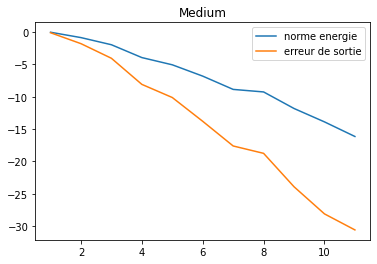

In [39]:
plt.plot(np.linspace(1,modele.N,modele.N),np.log(tab_max_norme_energie),label="norme energie")
plt.plot(np.linspace(1,modele.N,modele.N),np.log(tab_max_output_error),label="erreur de sortie")
plt.title("Medium")
plt.legend();

### Question 3

Le nombre de Biot est directement lié à la méthode de refroidissement, des taux de refroidissement plus élevés (Bi plus élevé) impliquent un $T_{root}$ plus faible (meilleur) mais aussi des coûts initiaux et opérationnels plus élevés (moins bons).

On peut donc définir une fonction de coût total comme suit
$$C(Bi) = Bi + T_{root}(Bi)$$
dont la minimisation donne une solution optimale. 

Appliquons alors notre calcul réduit online) de la base réduite pour $T_{root\;N} pour trouver le Bi optimal.

In [40]:
from numpy import infty

tab_Bi=np.linspace(0.01,1,100)
C_Bi=[]
for Bi in tab_Bi:
    mu = construct_mu(Bi)
    T_root_N = modele.get_T_root_N(mu)
    C_Bi.append(Bi+T_root_N)
print("Bi =",tab_Bi[np.argmin(C_Bi)]," ; C(Bi) =",np.min(C_Bi))
    

Bi = 0.4  ; C(Bi) = 1.465520860357727


## Question d

On considère maintenant que les $k_i$ sont équivalent $k_1=k_2=k_3=k_4$ et qu'ils peuvent varier de 0.1 à 10 et que le nombre de Biot Bi peut lui aussi varier entre 0.01 et 1.

On considère également l'échantiallon `RB_sample.sample3` avec un maillage `coarse`.

On introduit cette-fois deux échantillons $test$ de taille 100 pour faire varier k_i entre 0.1 et 10 et Bi entre 0.01 et 1. 

On cherche à plot la maximum de notre erreur relative pour la norme d'énergie :
$$max_{\mu\in test}\frac{|||u(\mu)-u_N(\mu)|||_\mu}{|||u(\mu)|||_\mu}$$
et le maximum de l'erreur relative sur notre sortie:
$$max_{\mu\in test}\frac{|T_{root}(\mu)-T_{root\; N}(\mu)|}{T_{root}(\mu)}$$

In [41]:
sample=3

In [42]:
modele = reduce_basis('coarse',sample,True) #Gram-Schmidt

In [43]:
def construct_mu(k_i,Bi):
    return np.array([k_i, k_i, k_i, k_i, 1., Bi])

In [44]:
def error(modele):
    mu_prod = np.array([1., 1., 1., 1., 1., 0.1])
    A_prod = modele.get_A_N_cal(mu_prod)

    tab_k_i=np.linspace(0.1,10,20)
    tab_Bi=np.linspace(0.01,1,20)
    tab_max_norme_energie=[]
    tab_max_output_error=[]
    for n in range(1,modele.N+1):
        modele.change_N(n)
        max_norme_energie=0
        max_output_error=0
        for k_i in tab_k_i:
            for Bi in tab_Bi:
                mu = construct_mu(k_i,Bi)

                u_N = modele.get_u_N(mu)
                u_N_cal = modele.get_u_N_cal(mu)
                val = modele.norme(u_N_cal-modele.Z@u_N,A_prod)/modele.norme(u_N_cal,A_prod)
                # = np.sqrt(T_root_N_cal-T_root_N)/modele.norme(u_N_cal,A_prod)
                if(val>max_norme_energie):
                    max_norme_energie=val
                
                T_root_N_cal = modele.get_T_root_N_cal(mu)
                T_root_N = modele.get_T_root_N(mu)
                
                val = np.abs(T_root_N_cal-T_root_N)/T_root_N_cal
                if(val>max_output_error):
                    max_output_error=val
        
        tab_max_norme_energie.append(max_norme_energie)
        tab_max_output_error.append(max_output_error)

    return tab_max_norme_energie,tab_max_output_error

In [45]:
tab_max_norme_energie,tab_max_output_error=error(modele)

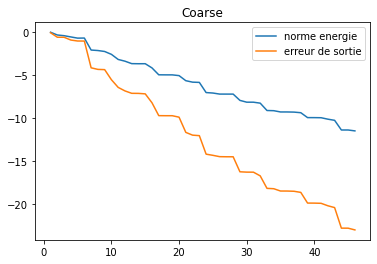

In [46]:
plt.plot(np.linspace(1,modele.N,modele.N),np.log(tab_max_norme_energie),label="norme energie")
plt.plot(np.linspace(1,modele.N,modele.N),np.log(tab_max_output_error),label="erreur de sortie")
plt.title("Coarse")
plt.legend();